# 02 Simulated Annealing to Help The Salesman

In [1]:
# packages import
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme(style="white")
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

## A. Motivation

Markov-Chain Monte-Carlo method consist of 2 main concepts. Sample proposal and acceptance/rejection criteria. Simulated Annealing (especially applied to Traveling Salesman Problem) provides a clear intuition about the 2 concepts.

Moreover, one of the most popular sampling algorithm in MCMC is called Metropolis-Hasting. It has nothing to do with Simulated Annealing algorithm except both of them are variation of Monte-Carlo but with very different purposes. Simulated Annealing is applied for optimization tasks, while Metroplis-Hasting's application is in statistical analysis. However, I find it fascinating that they work very similarly.

Furthermore when I dive into MCMC, I find that many sampling algorithm used in MCMC for Bayesian analysis has analogous algorithms for optimization tasks (will get to that later). So by learning MCMC, it's like I can learn 2 things at the same time: Statistical analysis and Optimization.

## B. The Simulated Annealing

Simulated Annealing is an optimization method inspired by the [annealing process in metallurgy](https://en.wikipedia.org/wiki/Annealing_(materials_science)), where a material is heated and then slowly cooled down until it reaches a state of minimum energy.

At each discretized time step $t$, a system is at state $S_t$ with an associated energy $E(S_t)$. A new state $S_{t+1}$ is then proposed, with energy $E(S_{t+1})$ (i..e the proposed state is accepted). The probability of the system moving from $S_t$ to $S_{t+1}$ is given by;
$$
P(S_t \rightarrow S_{t+1}) = \min{\left(1, \text{exp}\left(\frac{-\Delta E}{T_t}\right)\right)}
$$
where $\Delta E = E(S_{t+1}) - E(S_t)$ and $T_t$ is temperature of the system at time step $t$. After each time step, the temperature will be reduce at a _cooling rate_ $\alpha$ so that the next temperature $T_{t+1}$ is given by;
$$
T_{t+1} = (1 - \alpha) T_t \quad (0 < \alpha < 1)
$$
Parameter $\alpha$ is called _annealing schedule_ and the condition $0 < \alpha < 1$ resembles the annealing (gradual cooling) process in metallurgy. The process is kept running until the temperature reach some target value, $T_t \approx 0$ (close to zero), at which we said that the system has reached its lowest energy. The final state $S_\text{final}$ at this lowest energy is then our estimated optimal solution to the prolem we are trying to solve.

## C. Traveling Salesman Problem

For those who are not familiar with Traveling Salesman Problem, here is the problem statement;
> _Given a list of $N$ cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?_

For simplicity, let's consider $N$ points located in $(X_i, Y_i)$ on cartesian coordinates like illustrated in the graph below. Each dot is a city that the salesman must visit exactly once. Distance between a pair of city-$i$ and city-$j$ is simply euclidean distance, $d_{ij} = \sqrt{(X_i - Xj)^2 + (Y_i - Y_j)^2}$.

### NP-Hard Problem

In Computational Complexity Theory, the Traveling Salesman Problem belongs to NP-Hard category. Find an **exact solution** requires exponential time. The simplest method to find and exact solution is by brute-force trying all the possibilities, which then will result in time complexity of $O(n!)$. Using dynamic programming, [Held-Karp Algorithm](https://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm) can solve if in $O(n^2 2^n)$. To give a sense of scale, in a large system of $N > 100$, it will take at least 1000 years running in an average modern computer. I got this numbers from ChatGPT so I can't cite the source. But I basically want to say that for large $N$, getting the exact solution is practically challenging. Henceforth, we are going **estimate** the solution using Simulated Annealing. Although it is not the global optimum solution, in terms of real-world practicality it's good enough solution provided we can get it in only minutes.

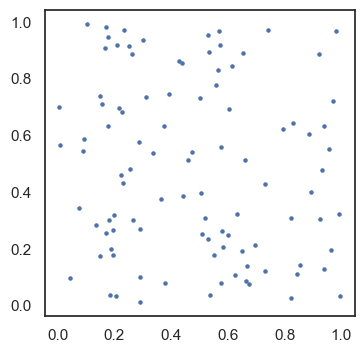

In [2]:
# Draw lustration of the Traveling Salesman problem.
# Each dot is a city the salesman need to visit exactly once.

# initialize random points
N = 100
X, Y = np.random.uniform(0,1,N), np.random.uniform(0,1,N)

# initialize axis to plot
fig, ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal')

# plot random points
ax.scatter(X, Y, s=5)
plt.show()

## D. Reconstructing TSP into Simulated Annealing

### 1. Initial State
The initial state is our **initial guess** of what the best route is. There are multiple ways to decide the initial state. Let's just try the simplest initial state $S_t = (0 \rightarrow 1 \rightarrow 2 \rightarrow 3 \rightarrow ... \rightarrow N-1 \rightarrow  N)$, this is equivalent to random route because the points are generated randomly.

### 2. Energy Function
Energy is the quantity that we are trying to minimize or maximize. In TSP, we want to minimze the total travel distance to visit all cities exactly once. So we can define the energy function as 
$$
E(S) = \sum_{i=0}^{N-1}{d(s_i, s_{i + 1})}
$$
where $d(s_i, s_{i + 1})$ is euclidean distance between two consecutive nodes in our route. 

### 3. Perturbation (for State Transition Proposal)
At each time-step we will propose a new state $S_{t+1}$ by perturbing the current state $S_t$. The perturbation is done by slightly shuflling the current state/route using 3 perturbation functions: swapping, shuffling subroute, and reversing subroute. Why these 3 functions, you may ask. See the **Reflection** section at the end of the notebook.

After we proposed the new state $S_{t+1}$. calculate the energy of the new state, $E(S_{t+1})$. The new state proposal will be accepted/rejected based on this probability of acceptance;
$$
P(S_t \rightarrow S_{t+1}) = \min{\left(1, \text{exp}\left(\frac{-\Delta E}{T_t}\right)\right)} \text{,   }
$$
where $\Delta E = E(S_{t+1}) - E(S_t)$.

### 4. Initial Temperature and Annealing Schedule

The acceptance probability depends on $1/T_t$, temperature. The higher the $T$ the more likely a bad proposal is accepted. So we have to define the initial temperature and the annealing schedule. The annealing schedule is the rate at which we decrease the temperature at the next step. In this case, let's pick initial temperature $T_0=0.05$ and set the annealing rate parameter $\alpha = 2.5 \times 10^{-5}$, so that we schedule the cooling by;
$$
T_{t} = T_0 (1-\alpha)^{t}
$$
For why I setup the annealing parameters ($T_0$ and $\alpha$) and the schedule formula, see the **Reflection** section at the end of the notebook.

In [3]:
# Code to run sumulated annealing 
from utils.math_utils import euclidean_distance

def compute_energy(S, X, Y):
    """
    Energy defined as total distance of the route
        s: array of nodes in order representing the travel route
        X: array of position of each node in x-coordinate
        Y: array of position of each node in y-coordinate
        return float, total travel distance of the route and back to original position.
    """
    N = len(S)
    E = 0
    for i in range(1, N):
        # travel along the route
        _from, _to = S[i-1], S[i]
        
        E += euclidean_distance(
            (X[_from], Y[_from]),
            (X[_to], Y[_to])
        )
        
    return E

def compute_acceptance_probability(deltaE, T):
    """
    Decide to accept or reject the proposed state/route based on energy change and temperature
        deltaE: float, changes in energy
        T: float, temperature
        return float, probability of acceptance
    """
    return np.min([1, np.exp(-1 * deltaE / T)])

def perturb(S):
    """
     Function to proposed new state
        by random shuffling the existing state
        S: array, current state
        return array, new proposed state
    """
    def swap(S):
        """
        Example: [1,2,3,4,5,6,7,8,9,10] --> [1,2,8,4,5,6,7,3,9,10] (3 and 8 are swapped)
        """
        i, j = np.random.choice(len(S), size=2, replace=False)
        S[i], S[j] = S[j], S[i]
        return S
        
    def shuffle_subroute(S):
        """
        Example: [1,2,3,4,5,6,7,8,9,10] --> [1,2,3,7,4,5,8,6,9,10]
        """
        left, right = np.random.choice(len(S), size=2, replace=False)
        subroute = S[left:right]
        np.random.shuffle(subroute)
        S[left:right] = subroute
        return S
        
    def reverse_subroute(S):
        """
        Example: [1,2,3,4,5,6,7,8,9,10] --> [1,2,3,8,7,6,5,4,9,10]
        """
        left, right = np.random.choice(len(S), size=2, replace=False)
        S[left:right] = S[left:right][::-1]
        return S

    S_ = S.copy() # avoid modifying S
    k = np.random.choice(3)
    if k == 0:
        S_[1:] = swap(S_[1:])
    elif k == 1:
        S_[1:] = shuffle_subroute(S_[1:])
    elif k == 2:
        S_[1:] = reverse_subroute(S_[1:])
    return S_

In [4]:
# MAIN SIMULATION it will take a while, so be patient...

N = len(X) # number of nodes
S = np.arange(N) # initial state as random route
energy_evolution = [] # placeholder to keep track the evolution of energy
temperature_evolution = []
states = [] # placeholder to keep track the evolution of states

T0 = 0.035 # initial temperature
alpha = 2.5e-5 # annealing rate
ts, T = 0, T0

start_time = time.time()
while T > 1e-10 or ts==0: # we keep doing the process until the temperature is small enough
    # calculate current energy and keep track of the state
    E = compute_energy(S, X, Y)
    energy_evolution.append(E) # keep track of the energy
    states.append(S) # keep track of the state
    temperature_evolution.append(T) # keep track of the temperature
    
    # propose new state
    S_new = perturb(S) # proposed new state to move from current state S
    E_new = compute_energy(S_new, X, Y) # calculate the energy of the proposed state

    # accept or reject the proposed new state
    P = compute_acceptance_probability((E_new - E), T) # calculate the acceptance probability based on deltaE and T
    S = S_new if np.random.uniform(0, 1) < P else S # randomly transition to S_new or stay at S based on P

    # Annealing schedule
    ts += 1
    T = T0 * (1 - alpha)**ts
end_time = time.time()

energy_evolution = np.array(energy_evolution) # convert to numpy array
temperature_evolution = np.array(temperature_evolution)

print(f"--- Simulation finished in {((end_time - start_time)/60):.2f} minutes ---")
print(f"Initial Energy (Random route): {energy_evolution[0]}")
print(f"Final Energy (Optimized route): {energy_evolution[-1]}")

--- Simulation finished in 8.34 minutes ---
Initial Energy (Random route): 53.22135524041559
Final Energy (Optimized route): 8.696728502895214


## Validation with Greedy Algorithm

It is amazing that in only 6 minutes running time, we can reduce the total distance quite significanlty. But how can we validate if the final solution is good enough?

Since it's very difficult to obtain the exact solution of TSP, we will validate our solution with Greedy Algorithm. Solving TSP with greedy algorithm basically starts with initial nodes (any nodes), then move to the next node where it is the nearest neighbor from the current node. Repeat the process without revisiting previously visited nodes until all the nodes are visited.

The greedy algorithm is a decent benchmark because it is intuitive. If you are the salesman starting your trip from one location, most of the people would pick the nearest location to be visited next. This solution is very logical, right? But we will see that it is not the most optimum solution.

In [5]:
# computing solution with greedy algorithm

def greedy_route(X, Y):
    """
    Generate a TSP route by greedy algorithm
        X: array of position of each node in x-coordinate
        Y: array of position of each node in y-coordinate
        return array representing the greedy route
    """
    N = len(X)
    XY = np.column_stack((X,Y))
    s = [0] # starting at node-0
    for i in range(N - 1):
        # move to the nearest neighbor node
        current_node = s[i]
        current_xy = XY[current_node]
        distances = np.sqrt(np.sum((current_xy - XY)**2, axis=1))
        distances[[j for j in s]] = np.inf
        next_node = np.argmin(distances)
        s.append(next_node)
    return np.array(s)

S_greedy = greedy_route(X, Y)
greedy_energy = compute_energy(S_greedy, X, Y)
print(f"Greedy energy: {greedy_energy}")
improvement = (greedy_energy*1.0/energy_evolution[-1] - 1)*100
print(f"Greedy solution is {improvement:.2f}% worse than Simulated Annealing")

Greedy energy: 10.237063808582654
Greedy solution is 17.71% worse than Simulated Annealing


The Greedy solution gives a route with total distance 13.56% worse than Simulated Annealing. Asking ChatGPT, Greedy solution usually gives result that is 10% - 20% worse than global optimum solution. Can't say how true it is, but if so then our solution could probably be pretty close to the global optimum solution.

## Visualization

Plot our simulation and the final optimized TSP route, and putting it side by side with Greedy route for comparison

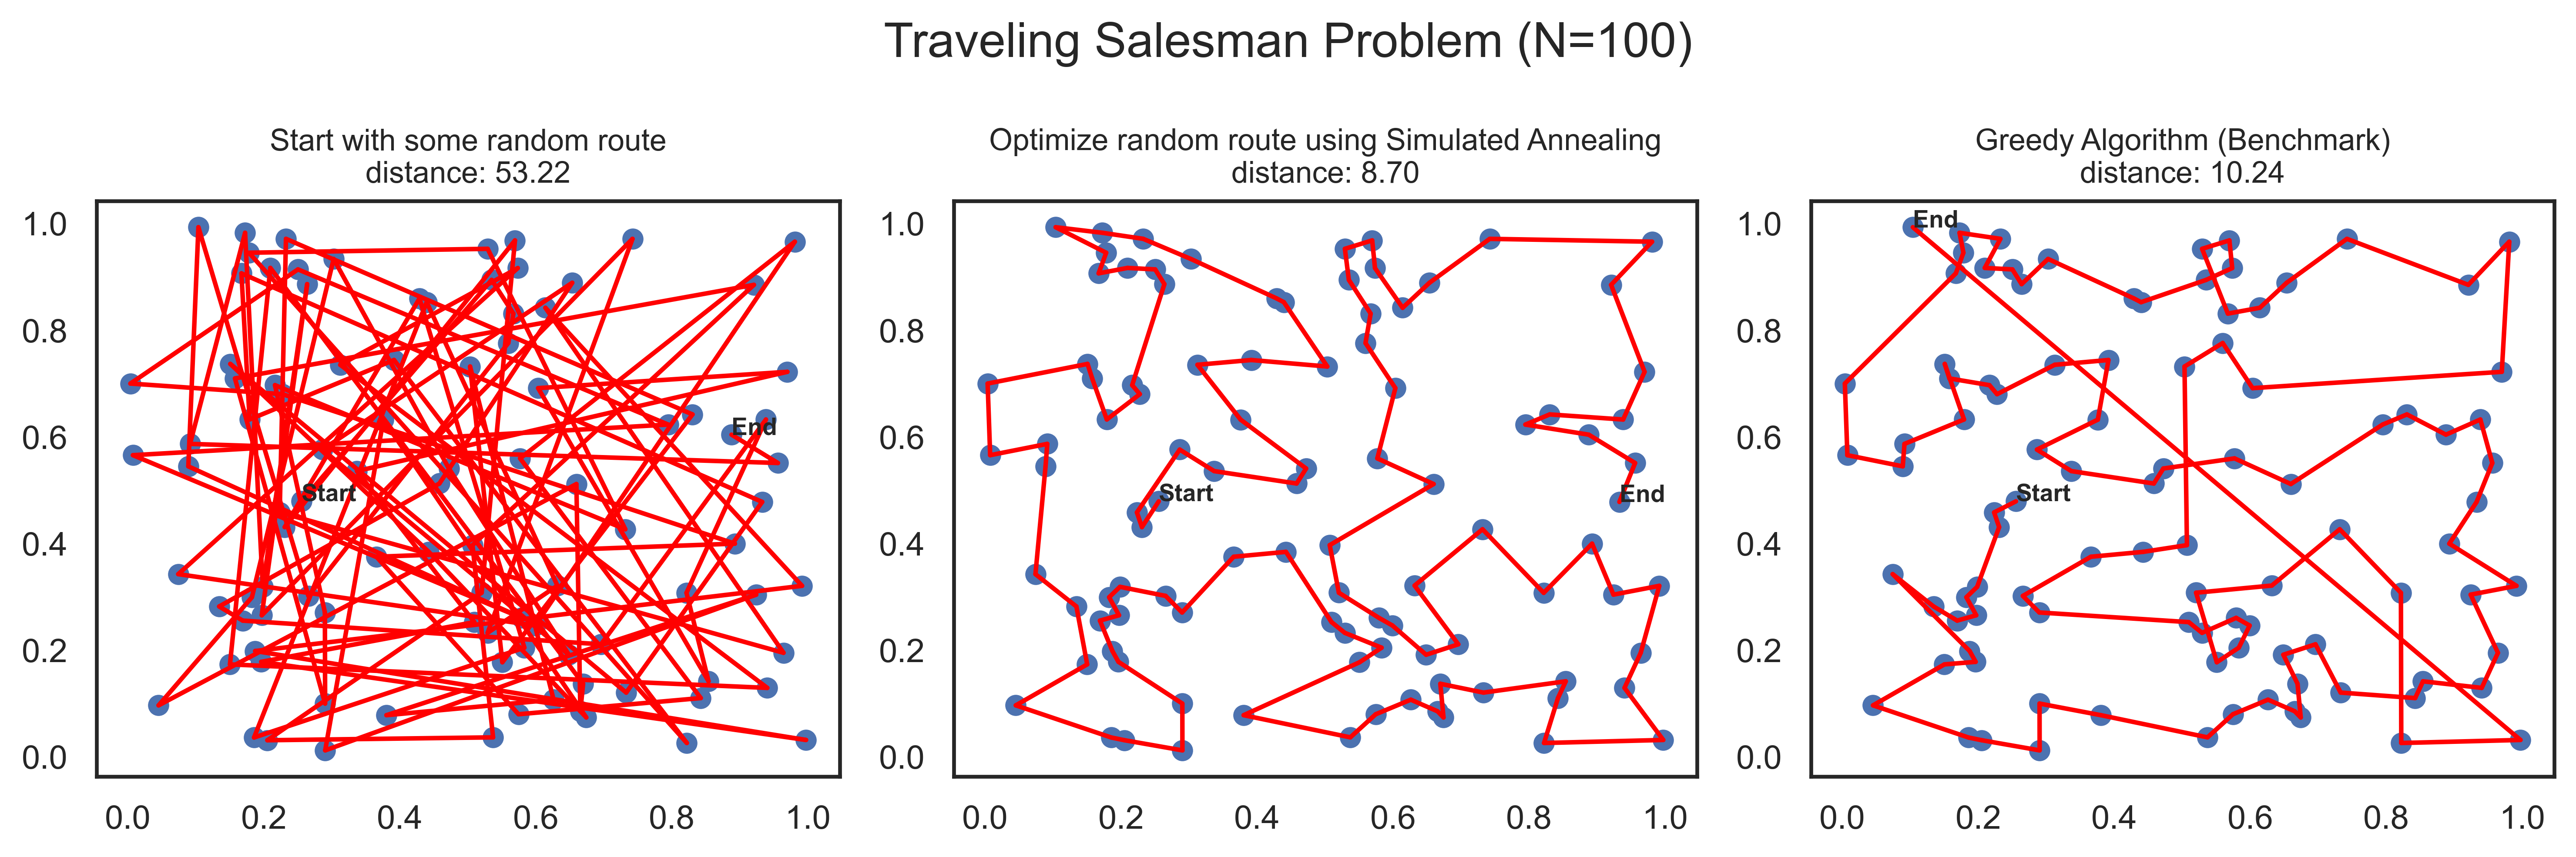

In [6]:
# Plot and animate the simulation (animation file is stored in output/ folder)

import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 512

def plot_route(X, Y, S, ax):
    for i in range(1, len(S)):
        _from, _to = S[i-1], S[i]
        ax.plot(X[[_from,_to]], Y[[_from,_to]], '-', c='red')
    X_start, X_end = X[S[0]], X[S[-1]]
    Y_start, Y_end = Y[S[0]], Y[S[-1]]
    # ax.plot([X_end,X_start], [Y_end,Y_start], '-', c='red')
    ax.annotate('Start', (X_start, Y_start), weight='bold', fontsize=8)
    ax.annotate('End', (X_end, Y_end), weight='bold', fontsize=8)
    return ax

fig = plt.figure(tight_layout=False, figsize=(12,4))
fig.dpi = 500
fig.suptitle(f"Traveling Salesman Problem (N={len(X)})", fontsize=16)

grid = gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(grid[:,0])
ax2 = fig.add_subplot(grid[:,1])
ax3 = fig.add_subplot(grid[:,2])
# ax1.set_aspect('equal'); ax2.set_aspect('equal')
ax1.scatter(X, Y); ax2.scatter(X, Y); ax3.scatter(X, Y)
ax1.set_title(f'Start with some random route\ndistance: {energy_evolution[0]:.2f}', fontsize=10)
ax2.set_title(f'Optimize ther random route using Simulated Annealing\ndistance: {energy_evolution[-1]:.2f}', fontsize=10)
ax3.set_title(f'Greedy Algorithm (Benchmark)\ndistance: {greedy_energy:.2f}', fontsize=10)

S_init, S_final = states[0], states[-1]
ax1 = plot_route(X, Y, S_init, ax1)
ax2 = plot_route(X, Y, S_init, ax2)
ax3 = plot_route(X, Y, S_greedy, ax3)

n_frames = 250
N = len(states)
frames = np.floor(np.exp(np.linspace(0, np.log(N - 1), n_frames))).astype(int)
frames[:100] = np.arange(0, 200, 2)
frames.sort()
n_frames = len(frames)

def animate_simulated_annealing(frame): 
    ax2.clear()
    ax2.scatter(X, Y)
    ts = frames[frame]
    ax2.set_title(f'Optimize random route using Simulated Annealing\ndistance: {energy_evolution[ts]:.2f}', fontsize=10)
    S_frame = states[ts]
    plot_route(X, Y, S_frame, ax2)

# PICK YOUR PREFERED OUTPUT OF THE ANIMATION
# To export the animation as file
anim = FuncAnimation(fig, func=animate_simulated_annealing, frames=n_frames, repeat=False, blit=False)
anim.save(filename="outputs/02_simulated_annealing_traveling_salesman_problem.mp4", writer="ffmpeg", fps=20)

# plot static image of the last frame
animate_simulated_annealing(frame=n_frames - 1)
plt.show()


## Temperature and Energy Curve

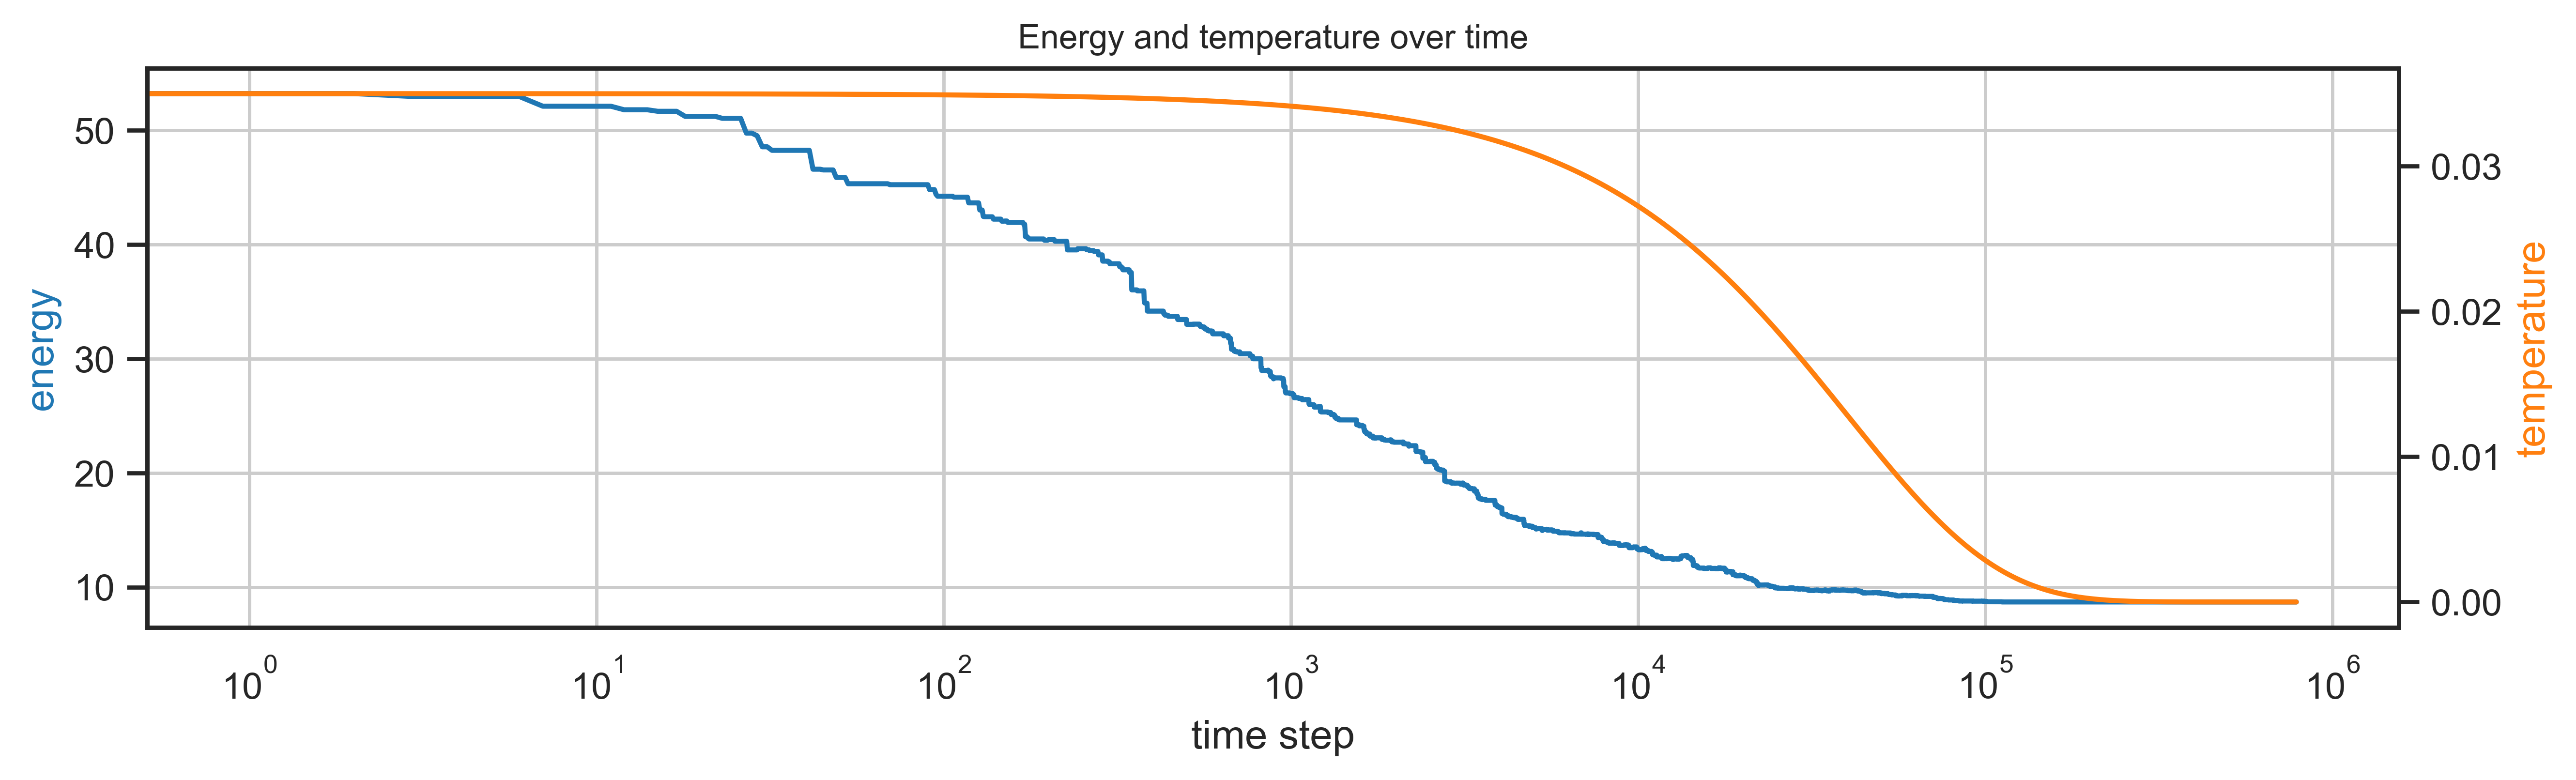

In [7]:
# Plot the energy and temperature over time 

fig, ax4 = plt.subplots(figsize=(12,3))
fig.dpi = 500
ax4.semilogx()
ax4_right = ax4.twinx()
ax4.plot(energy_evolution, c='tab:blue', label='energy (left)')
ax4_right.plot(temperature_evolution, c='tab:orange', label='temperature (right)')
ax4.set_title("Energy and temperature over time", fontsize=10)
ax4.set_xlabel("time step")
ax4.set_ylabel("energy", color='tab:blue')
ax4_right.set_ylabel("temperature", color='tab:orange')
ax4.grid()
plt.show()

## C. Reflection

The most important characteristic of this process is the temperature curve. In the temperature curve above, I would say that the entire algorithm can be splitted into 3 phases
1. During the first $10^3$ iterations, Temperature is kept high. At this phase, we maximize the search space.
2. Then we gradually lower the temperature until after $10^5$ iterations, I called this the optimization phase.
3. Finally the last phase I called it the refinement phase where temperature stays low and we don't change our solution much, only to refine a little parts of our solution before finishing the process

Deciding the shape of the temperature curve, i.e. when each of the 3 phases above starts and ends, is crucial to get the most optimum solution out of Simulated Annealing. The shape of the curve is governed by the parameters $T_0$ and $\alpha$ through the annealing schedule function;
$$
T_t = T_0 (1 - \alpha)^t
$$

For this particular cases of TSP with N=100 random points, I found that the function above and the parameter values of $T_0 = 0.03$ and $\alpha=3\times10^{-5}$ to be the most optimum. I found it through doing a lot of trials and running the simulation multiple times. Not only the annealing function, the perturbation functions to proposed new states were also found iteratively throuh many trials. Maybe there are better annealing functions and perturbation functions, which I might try again later but for now I'm quite satisfied.

### Controlling Randomness

One other thing that I learn from this excerise is about controlling randomness. It's interesting to me that we can use a random process to solve a structured and deterministing problem such as Traveling Salesman Problem. When I reflect, the key is in how we can guide the random process so it eventually falls into our desired outcomes. In this case, we control it using the acceptance probability function and the annealing schedule function.

## D. Resemblance with Metropolis-Hasting Algorithm

The reason I decided to learn about Simulated Annealing is to familiarize myself with Metropolis-Hasting algoritm, which is one of the main sampling algorithm used in Markov-Chain Monte-Carlo. I find it fascinating that the acceptance probability in Simulated Annealing is very similar to that of Metropolis-Hasting algorithm despite they are totally different algorithm with totally different puropsoe. Here is how they are very similar;

In statistical context, the energy term ($E$) in Simulated Annealing can be thought of analogous to the _negative log likelihood_, $\mathcal{L}$. We can write;
$$
E(S_t) \sim -\log(\mathcal{L}(S_t))
$$
It follows;
$$
- \Delta E \sim \log\left(\frac{\mathcal{L}(S_{t+1})}{\mathcal{L}(S_t)}\right)
$$
Substituting this into the formula for $P(\text{accept})$ in Simulated Annealing, we get;
$$
P(\text{accept}) = \min\left(1, \left(\frac{\mathcal{L}(S_{t+1})}{\mathcal{L}(S_t)}\right)^{1/T_t}\right)
$$

This form is similar to the probability of acceptance in Metropolis-Hasting algorithm, one of the most commont MCMC sampling algorithm. The main difference is in the term $1/T_t$, where it usually does not exist in Metropolis-Hasting. In other words, Metropolis-Hasting algorithm can be seen as a special case of Simmulated Annealing with constant temperature, often $T=1$. 

_So what does this difference mean?_ The purpose of Simulated Annealing is optimization where we want the system to fall on a final state $S_\text{final}$. Hence, we want the process to eventually stop (we don't want to run the simulation up to infinity), and we set the strict criterion as when $T_t \approx 0$, just as the real physical metallurgy annealing process uses a target temperature. However, in Bayesian Inference using MCMC we want to be able to sample the posterior distribution as accurately as possible to reality. Therefore, we don't impose an exact the stopping criteria to pur sampling algorithm (i.e. the Metropolis-Hasting algorithm). 

We can also say more precisely;
> _Simulated Annealing gradually narrows the search space by coling down over time to get a final optimal state,  
> while Metropolis-Hasting keeps the search space fixed to aim for unbiased sampling from a probability distribution_

# End of The Notebook